In [2]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import cv2


## **1️⃣ Préparation des données** *(En cours 🚀)*  


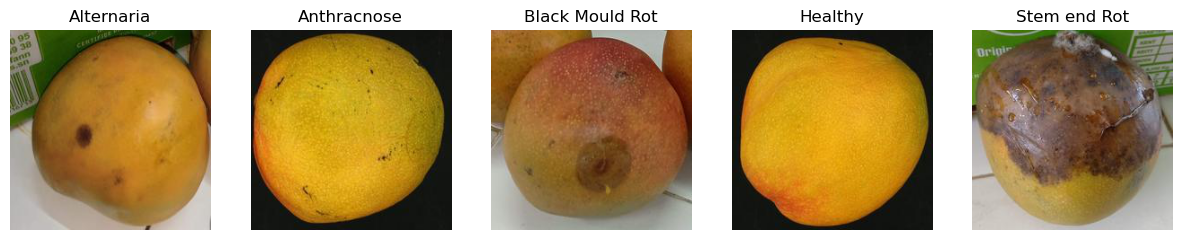

In [3]:
# Étape 1 : Chargement des données
data_dir = "SenMangoFruitDDS_original"
classes = ["Alternaria", "Anthracnose", "Black Mould Rot", "Healthy", "Stem end Rot"]

# Afficher une image de chaque classe
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    img_name = os.listdir(class_dir)[1]  # Prendre la première image de chaque classe
    img_path = os.path.join(class_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.show()


In [4]:
# Étape 2 : Prétraitement des données
def load_and_preprocess_data(data_dir, classes, img_size=(224, 224)):
    images = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)  # Prétraitement pour ResNet
            images.append(img_array)
            labels.append(class_idx)

    return np.array(images), np.array(labels)

In [5]:
# Charger et prétraiter les données
X, y = load_and_preprocess_data(data_dir, classes)

# Diviser les données en ensembles d'entraînement et de test
# 🔹 Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
print("Les 5 premiers labels de y_train :", y_train[2:7])

Les 5 premiers labels de y_train : [2 4 3 0 2]


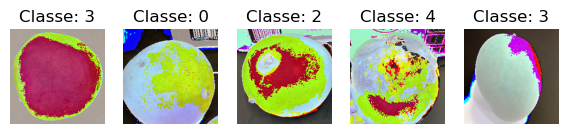

In [7]:
# Affichage des 5 premières images de X_train
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(2, 7, i + 1)
    plt.imshow(X_train[i].astype("uint8"))  # Conversion pour affichage correct
    plt.title(f"Classe: {y_train[i]}")
    plt.axis("off")

plt.show()


## **2️⃣ Extraction de caractéristiques avec ResNet50**  
Nous utilisons **ResNet50** pré-entraîné sur ImageNet mais **sans la dernière couche de classification**. Cela nous permet d'extraire les **features** sans entraîner le modèle sur ImageNet.

✅ **Objectif** : Utiliser un réseau pré-entraîné pour extraire des features des images.  
  

- Charger **ResNet50 pré-entraîné** (sans la dernière couche).
- pooling="avg" dans ResNet-50
Cette option réduit la taille des caractéristiques extraites par le réseau et résume l’information de l’image

In [8]:
# Charger ResNet50 pré-entraîné, sans la couche de classification (include_top=False)
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# 🔹 Fonction d'extraction des features
def extract_features(model, X):
    return model.predict(X, batch_size=32, verbose=1)

# 🔹 Extraction des caractéristiques
X_train_features = extract_features(base_model, X_train)
X_test_features = extract_features(base_model, X_test)



6/6 [==============================] - 50s 9s/step


- Sauvegarde des features pour Appliquer une méthode de **stacking** en combinant plusieurs classificateurs, notamment **KNN, Random Forest et SVM**.

Puisque l’extraction prend du temps, on sauvegarde les features pour éviter de recommencer

In [9]:
# 🔹 Sauvegarde sous CSV
pd.DataFrame(X_train_features).to_csv("train_features.csv", index=False)
pd.DataFrame(y_train).to_csv("train_labels.csv", index=False)
pd.DataFrame(X_test_features).to_csv("test_features.csv", index=False)
pd.DataFrame(y_test).to_csv("test_labels.csv", index=False)

In [10]:
df1=pd.read_csv("train_features.csv")
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.642518,0.596101,0.000000,0.274475,0.089044,0.000000,0.006672,0.000000,0.0,0.030932,...,0.472832,0.000000,0.505096,0.141543,0.576853,0.000000,0.000000,3.481980,1.658191,0.000000
1,0.079772,1.080760,0.134744,0.297323,0.000000,0.058310,0.349213,1.284848,0.0,0.022845,...,0.196848,0.000000,0.651722,0.000000,0.321209,0.000000,0.077988,0.977419,0.693687,0.161374
2,0.856379,0.721093,0.139525,0.215278,0.251042,0.201798,0.289079,0.408205,0.0,0.180148,...,0.083577,0.000000,1.123193,0.070406,0.168884,0.000000,0.053620,3.564493,0.589932,0.868907
3,0.094315,2.070337,0.873561,0.221294,0.023776,0.115570,0.228523,0.004044,0.0,0.410078,...,0.042213,0.064155,0.925754,0.039170,0.254503,0.308814,0.137813,1.628734,0.311601,0.061227
4,1.494387,0.033840,0.616532,0.150859,0.004491,0.000000,0.000000,0.091137,0.0,0.000000,...,0.000000,0.000000,0.305837,0.000000,0.200081,0.000000,0.000000,4.246028,0.061101,0.000000


In [11]:
df1.shape

(687, 2048)

In [12]:
df2=pd.read_csv("test_features.csv")
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.570730,0.779059,0.384560,0.457049,0.023862,0.158888,0.000000,0.000000,0.037249,0.390344,...,0.000000,0.008556,0.578290,0.000375,0.464407,0.000000,0.000000,1.495602,2.486721,0.000000
1,0.835854,0.239002,0.135650,0.105908,0.000000,0.000000,0.051824,0.051832,0.000000,0.002492,...,0.039076,0.000000,0.921068,0.069480,0.235824,0.011888,0.008478,1.093355,0.103835,0.029922
2,0.300135,2.002635,0.482344,0.348529,0.040537,0.104735,0.731245,0.000000,0.000000,0.811253,...,0.000000,0.005434,2.208957,0.000000,0.525219,0.116053,0.008684,1.796767,0.042670,0.114564
3,0.141474,1.261518,0.544356,0.033760,0.012799,0.000000,0.038997,0.025298,0.007776,0.047540,...,0.048569,0.000000,1.373096,0.000000,1.549747,0.000000,0.162073,3.402487,0.258204,0.000000
4,0.608994,0.544921,1.042484,0.994068,0.048007,0.672749,0.394807,0.032251,0.000000,0.388607,...,0.062785,0.035505,3.313270,0.020889,0.584477,0.021148,0.097891,1.732949,0.740339,0.504843


In [13]:
df2.shape

(172, 2048)

## 3️⃣ **Entraînement des Modèles de Base & Stacking**

In [14]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# 🔹 Définition des modèles de base avec GridSearchCV
param_knn = {"n_neighbors": [2, 3, 4, 5]}
param_rf = {"n_estimators": [50, 100, 200], "max_depth": [10, 20, 30, None]}
param_svm = {"C": [0.1, 1, 10, 11], "kernel": ["linear", "rbf"]}
param_lgbm = {"num_leaves": [31, 40, 50], "n_estimators": [100, 200, 300]}


ModuleNotFoundError: No module named 'lightgbm'

- K-Nearest Neighbours (KNN)

In [ ]:
knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=5, n_jobs=-1).fit(X_train_features, y_train).best_estimator_

- Random Forest

In [ ]:
rf = GridSearchCV(RandomForestClassifier(), param_rf, cv=5, n_jobs=-1).fit(X_train_features, y_train).best_estimator_

-  Support Vector Machine (SVM)

In [ ]:
svm = GridSearchCV(SVC(probability=True), param_svm, cv=5, n_jobs=-1).fit(X_train_features, y_train).best_estimator_

- **Création du Stacking Classifier avec Random Forest**

In [ ]:
# 🔹 Création du Stacking Classifier
stacking_rf = StackingClassifier(estimators=[("knn", knn), ("rf", rf), ("svm", svm)], final_estimator=RandomForestClassifier(), cv=5)

- **Création du Stacking Classifier avec Régression Logistique**

In [ ]:
from sklearn.linear_model import LogisticRegression

stacking_log = StackingClassifier(
    estimators=[("knn", knn), ("rf", rf), ("svm", svm)], 
    final_estimator=LogisticRegression(),  # ✅ Remplacement de SVC par Logistic Regression
    cv=5
)


🔹 **Entraînement du modèle Random Forest**

In [ ]:
# 🔹 Entraînement
stacking_rf.fit(X_train_features, y_train)


StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=200)),
                               ('svm',
                                SVC(C=0.1, kernel='linear', probability=True))],
                   final_estimator=RandomForestClassifier())

🔹 **Entraînement du modèle Régression Logistique**

In [ ]:
stacking_log.fit(X_train_features, y_train)

StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=200)),
                               ('svm',
                                SVC(C=0.1, kernel='linear', probability=True))],
                   final_estimator=LogisticRegression())

## **4️⃣ Évaluation et comparaison des modèles**  


  
✅ **Objectif** : Mesurer la performance du modèle et explorer d'autres alternatives.  
### **Étapes :**  
1. **Calcul des métriques** :  
   - Matrice de confusion  
   - Précision, rappel, F1-score  
   - Courbe ROC-AUC  
2. **Comparaison les modèles** (Random Forest et regression logistique).  

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Prédictions
y_pred_rf = stacking_rf.predict(X_test_features)
y_pred_log = stacking_log.predict(X_test_features)

# 🔹 Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_log = accuracy_score(y_test, y_pred_log)

print(f"Accuracy Stacking avec RandomForest : {acc_rf:.4f}")
print(f"Accuracy Stacking avec Logistic Regression : {acc_log:.4f}")


Accuracy Stacking avec RandomForest : 0.8862
Accuracy Stacking avec Logistic Regression : 0.8982


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, log_loss, cohen_kappa_score
from sklearn.preprocessing import label_binarize

def plot_evaluation(model, X_test, y_test, model_name="Model"):
    # 🔹 Prédictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)  # Probas pour chaque classe

    # ✅ Vérification des shapes
    print(f"y_test shape: {y_test.shape}")  # Doit être (n_samples,)
    print(f"y_pred shape: {y_pred.shape}")  # Doit être (n_samples,)
    print(f"y_prob shape: {y_prob.shape}")  # Doit être (n_samples, 5)

    # 🔹 Convertir y_test en format binaire (One-vs-Rest) pour ROC-AUC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # 5 classes
    print(f"y_test_bin shape: {y_test_bin.shape}")  # Doit être (n_samples, 5)

    # 🔹 Vérification : Assurer que y_prob est bien 2D
    if len(y_prob.shape) == 1:
        raise ValueError("Erreur : y_prob est 1D, il doit être (n_samples, n_classes)")

    # 🔹 Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="macro")
    precision = precision_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    cross_entropy = log_loss(y_test, y_prob)
    kappa = cohen_kappa_score(y_test, y_pred)

    # 🔹 Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # 🔹 Graphique ROC multi-classes
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    colors = ["blue", "red", "green", "purple", "orange"]
    for i in range(5):  # 5 classes
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
        ax1.plot(fpr, tpr, color=colors[i], label=f'Classe {i} (AUC = {roc_auc:.2f})')

    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve Multi-Classe')
    ax1.legend(loc="lower right")

    # 🔹 Matrice de confusion avec pourcentages
    labels = np.asarray([f'{int(cm[i, j])}\n({cm_percent[i, j]:.1f}%)' for i in range(5) for j in range(5)]).reshape(5, 5)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax2)
    ax2.set_title('Confusion Matrix')
    ax2.set_xlabel('Prédiction')
    ax2.set_ylabel('Vérité')

    # 🔹 Tableau des métriques
    metrics_table = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-score": f1,
        "Cross-Entropy Loss": cross_entropy,
        "Cohen Kappa": kappa
    }
    ax3.axis('off')
    ax3.table(cellText=[[k, f"{v:.6f}"] for k, v in metrics_table.items()],
              colLabels=[model_name, "Value"],
              cellLoc='center',
              loc='center')
    ax3.set_title('Scores du Modèle')

    plt.tight_layout()
    plt.show()


y_test shape: (167,)
y_pred shape: (167,)
y_prob shape: (167, 5)
y_test_bin shape: (167, 5)


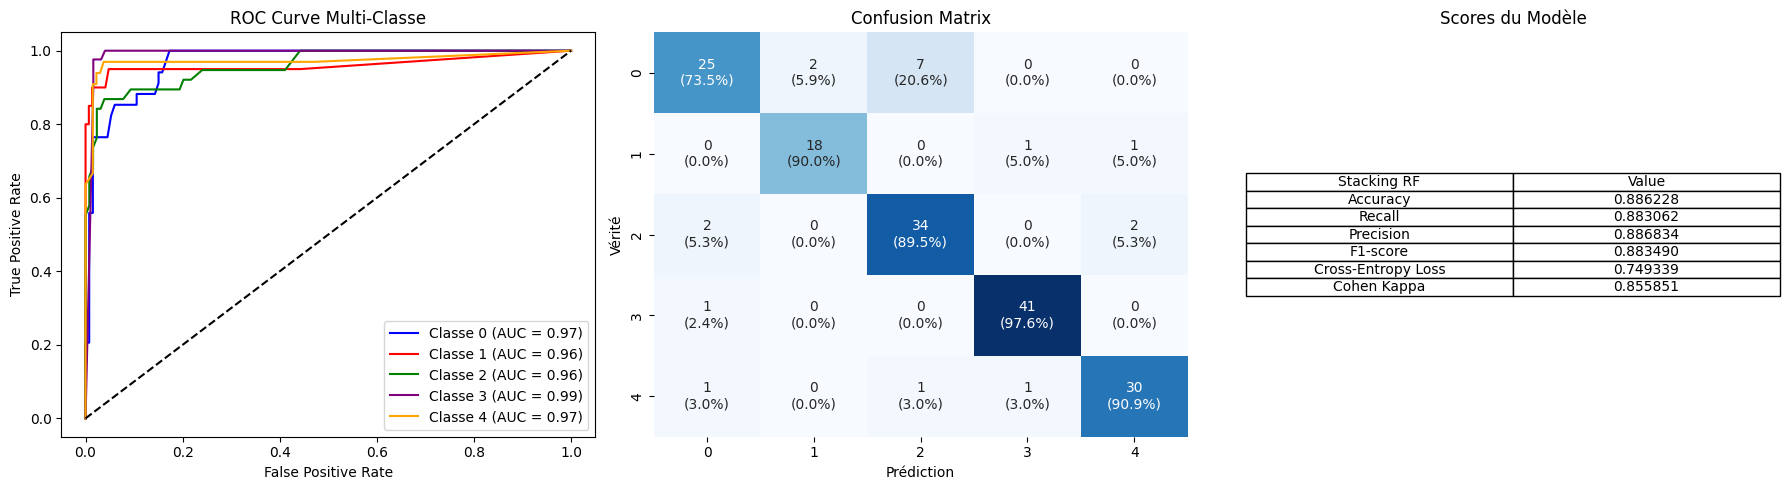

In [ ]:
plot_evaluation(stacking_rf, X_test_features, y_test, model_name="Stacking RF")


y_test shape: (167,)
y_pred shape: (167,)
y_prob shape: (167, 5)
y_test_bin shape: (167, 5)


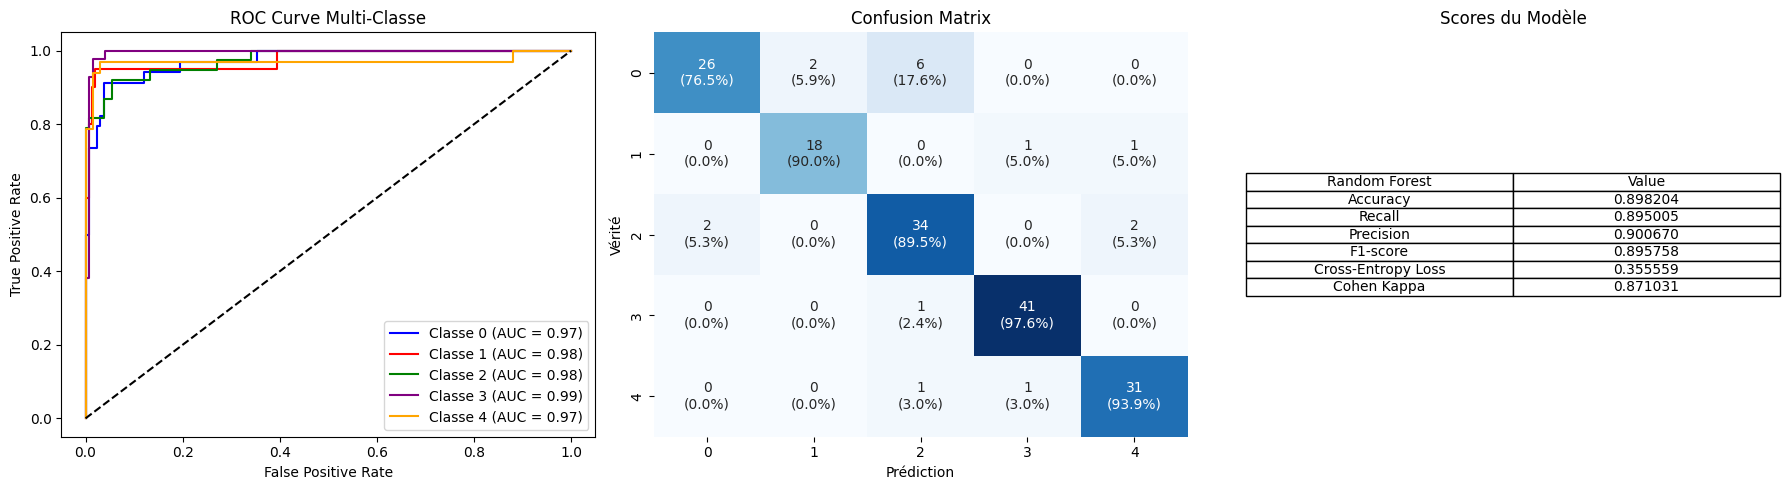

In [ ]:
plot_evaluation(stacking_log, X_test_features, y_test, model_name="Random Forest")